# Assignment 1a Notebook
This notebook will provide a series of tasks to guide you through the implementation of a random search algorithm. Conveniently, random search is often functionally equivalent to the random initialization step performed at the beginning of an evolutionary algorithm (EA), meaning this assignment is your first step towards a functioning EA. With that in mind, we'll try to structure this assignment so that you can reuse your code throughout the course as you implement the following assignments.

Make sure you are in the `EC-env` environment. If you are not, terminate the notebook server, run `conda activate EC-env`, and restart the notebook server.

Start by evaluating the next cell to configure the notebook. If this is your first time using a Jupyter notebook, you can press `shift+enter` to execute the Python code in a selected cell. This cell sets up some basic functionality that should make your development process easier, and imports all the components necessary to use the code we have provided.

In [1]:
# Configure this notebook to automatically reload modules as they're modified
# https://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

!pip install snake-eyes-parser

import warnings
warnings.filterwarnings('ignore') # hopefully stop any pedantic warnings

import matplotlib.pyplot as plt

%matplotlib widget
plt.rcParams['figure.figsize'] = (10.0, 3.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['figure.constrained_layout.use'] = True
plt.rcParams['font.size'] = 8.0
plt.rcParams['figure.titlesize'] = 12.0
plt.rcParams['axes.titlesize'] = 12.0
plt.rcParams['axes.labelsize'] = 8.0
plt.rcParams['figure.dpi'] = 100.0
plt.rcParams['savefig.dpi'] = 400.0

import multiprocessing

multiprocessing.set_start_method('fork', force=True)

from pathlib import Path
from cutting_stock.fitness_functions import base_fitness_function
from cutting_stock.visualizer import visualize
from snake_eyes import read_config
from linear_genotype import LinearGenotype

print('The first cell has been executed!')

The first cell has been executed!


## The Cutting Stock Problem
This semester we'll be exploring multiple problem domains where it may be appropriate to apply evolutionary computing (EC). There will be two assignment series in which you will create solutions to a cutting stock problem and evolve agents to play a simplified version of Ms. Pac-Man, respectively. In Assignment Series 1 (what you're doing now), your goal is to search for solutions to a 2-dimensional cutting stock problem (https://en.wikipedia.org/wiki/Cutting_stock_problem). This class is about EC, not cutting stock, so we have provided all the code related to the problem for you. The `cutting_stock` subdirectory holds this code, and you may treat it as a black box. You don't have to understand, modify, or even read the code within (unless you want to!), since we will introduce any necessary components to you in the notebooks as they become relevant. You do, however, need to understand the problem we are solving.

Our version of the 2-dimensional cutting stock problem can be thought of as follows: you have a rectangular sheet of metal stock, and the designs for several shapes you need to cut out of it. The shapes will be cut from the sheet by a cutting machine. The machine can only cut stock of a specific width, but can handle any length. Any stock you put into the machine is lost forever - either used as part of the output shapes, or wasted. Your objective, therefore, is to find an arrangement for the shapes that utilizes the smallest possible length of stock.

This problem is, in general, NP-hard: while there are some clever algorithms for generating good solutions, there is no known algorithm that can create perfectly optimal arrangements in a reasonable amount of time on sufficiently-complex problem instances. While we could ask you to write a custom solver for this problem, in this class we will pretend that this problem is a black box and apply minimal human knowledge or logic in the form of problem-specific heuristics\*. In such a case, an EA is often an effective tool for generating good solutions.

\*If this seems a bit contrived, rest assured that there are many such problems in the real world - they simply don't make for engaging course material. Cutting stock is a good fit for this class _because_ it is an intuitive and easy-to-understand problem, and you can visually judge how good a solution is.

### Problem Instances
We've just described the cutting stock problem in general terms as a problem class. However, for this assignment series, we will be working on two particular problem instances: an easy problem instance and a hard problem instance. That is, we have provided you two specific sets of shapes and specific dimensions for the stock. For a true comparison of algorithms on the cutting stock problem in general, they would need to be tested on a wide range of problem instances. Instead, we are using deliberately-designed problem instances for maximal pedagogical value, to facilitate simpler analysis, and to lessen the computational requirements for the course.

There are two different problem instances we will use during this assignment series; we will focus on the easy instance for our discussion here. In this easy instance, there are 10 different shapes that need to be placed on a sheet 15 cells wide (y-axis) and 50 cells long (x-axis). This is what the problem instance looks like, with the shapes neatly arranged on the stock:

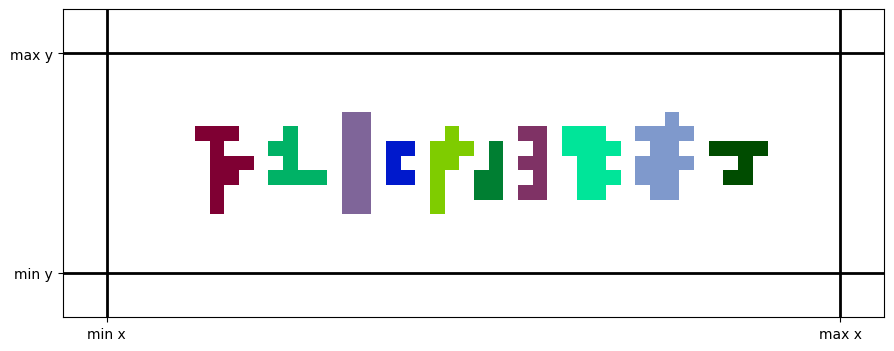

### Solutions
A solution to a cutting stock problem instance requires specifying where shapes are placed on the stock. A shape's placement on the stock can be defined by a translation and a rotation. Therefore, a solution consists of providing a translation and rotation for every shape.

A problem instance may have many, many different possible solutions. As you likely learned in class, the ability to determine which solutions are better than others is critical to the optimization process. Since the goal of the cutting stock problem is to minimize the length of stock used, we can score solutions by using a simple function that subtracts the length of stock used from the total length available:

<center>$score(solution) = available - used$</center>

where $available$ is the length of stock in the problem instance, and $used$ is the length of stock used by the solution. Then, intuitively, a solution's score represents how "good" it is; a higher score means a better solution. We calculate $used$ as the distance between the leftmost and rightmost cells occupied by the solution. The arrangement shown above uses 39 length, out of 50 available. As a solution, it would have a score of 11.

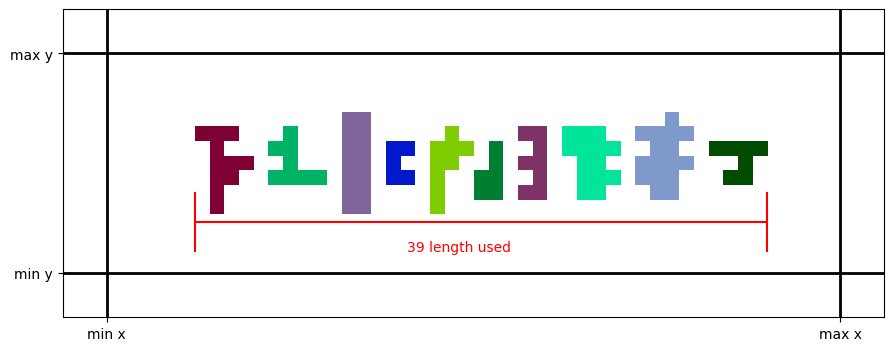

There are also many ways you could try to place shapes on the stock that simply don't make sense. For this problem, that would be any solution where shapes overlap or fall out-of-bounds. We call these invalid solutions, and assign them an arbitrary negative score (`-50`) rather than following the above equation.

## Implementation
Alright, onto the actual code. We'll only discuss the components that you should interact with, and will leave out unnecessary discussion of the lower-level implementation. If you get any errors that look like `NameError: name 'x' is not defined`, where `x` is one of the things we are about to discuss, you either have a typo or restarted your Python interpreter kernel (basically rebooting the program) and should re-run earlier code cells.

To avoid overloading you with more information than you really need, we will defer explanation of our configuration until the next assignment. We will provide you with all the code samples you'll need, so don't worry if you don't understand everything about how it's being used.

### Aside: Jupyter Notebook Hygiene
Note that a lot of the example cells in this course include `del` statements at the end which clear local variables. Notebook cells are not independent programs; variables persist between cell executions unless you restart the kernel. Careless reuse of variables defined in notebook cells is a frequent source of bugs. Examples of this include reusing the values of random variables, or appending to an existing list when you should have started a new one. There are some reasonable exceptions to this, like collecting your experimental data in one cell then conducting your analysis in another, or defining a function in one cell and running it in another\*. But you *must* be careful to not accidentally reuse variables in ways you didn't intend to! You don't need to `del` your variables (and it's generally a very unusual practice), we simply do it in these tutorials to ensure you can't haphazardly reuse example variables.

\*When doing this, remember that any changes you make to a function only apply if you execute the cell defining the function again. It's good practice to make a cell containing only functions, so you can execute it after any changes, and keep the actual function calls in a separate cell.

### Problem Specification
We define the cutting stock problem in terms of two variables: `shapes` and `bounds`, respectively describing the shapes and the stock they must be placed on. These may be found in `configs/1a/easy_config.txt`. Without getting into implementation details, `shapes` is a list, where each element describes one shape. Its only importance to you is its length, `len(shapes)`. `bounds` defines the dimensions of the stock:

* `bounds[0][0]` is $x_{min}$, the minimal x-coordinate on the stock (the left-hand boundary)
* `bounds[0][1]` is $x_{max}$, one plus the maximal x-coordinate on the stock (the right-hand boundary)
* `bounds[1][0]` is $y_{min}$, the minimal y-coordinate on the stock (the bottom boundary)
* `bounds[1][1]` is $y_{max}$, one plus the maximal y-coordinate on the stock (the top boundary)

In other words, the stock consists of all integral cooordinates such that `bounds[0][0] <= x < bounds[0][1]` and `bounds[1][0] <= y < bounds[1][1]`. Equivalently, this is the set $\{(x, y)\in\mathbb{Z}^2\ |\ x\in[x_{min}, x_{max})\ \&\ y\in[y_{min}, y_{max})\}$. Note this can be cleanly expressed using Python range notation:

`x_range = range(*bounds[0]) #equivalent to range(bounds[0][0], bounds[0][1])`

`y_range = range(*bounds[1]) #equivalent to range(bounds[1][0], bounds[1][1])`

### LinearGenotype
We've provided a partially-complete class (`LinearGenotype`) for your solution implementation. This is where you will begin to have considerable freedom in your implementations; you can use whatever data structures you want, so long as they meet our requirements. This is a good time to remind you that code practices contribute to your score, that your code will be meticulously graded _by hand_, and that we appreciate and remember students who consistently submit clean code.

#### Gene

As previously discussed, a solution to a cutting stock problem specifies a translation and rotation for every shape in the problem. Since the stock is 2-dimensional, translation is an `(x, y)` coordinate pair, where `x` and `y` are both in the bounds specified above. We will represent rotation with either `0`, `1`, `2`, or `3`, denoting a number of 90-degree clockwise turns. You will implement the translation and rotation for a shape as a single indexable data structure of the form `(x, y, r)`. That is, index `0` is the `x` value, index `1` is the `y` value, and index `2` is the rotation value. We recommend (but do not require) that you use a `tuple` or `list` for this data structure. In EC vocabulary this general structure is called a gene, while a specific instance of a gene is an allele.

#### Genotype

A gene describes the placement for one shape, but a solution to a cutting stock problem requires defining the placement of each shape. Therefore, a solution must be implemented such that `len(solution) == len(shapes)`, and `solution[i]` is a gene as described above. Then, we will use `solution[i]` to define the placement of `shapes[i]`. As with the genes, we recommend (but do not require) that you use a `tuple` or `list` for your solution data structure. In EC vocabulary, this solution structure is a fixed-length linear genotype. Fixed-length means there is a static number of loci (plural form of _locus_), which is a location for one gene, while linear is simply because the vector is 1-dimensional.

### LinearGenotype.random_initialization
That was a lot of information; good job for making it this far! For your first implementation task, implement the `LinearGenotype.random_initialization` method (found in the `linear_genotype.py` file) to get the following cell to work, and pass every test as `True`. This method should create a randomly-initialized solution as described above, where every value is chosen uniformly from its valid range. This function should store the generated solution in the `self.genes` member variable. *You can ignore the other methods of the `LinearGenotype` class until Assignment 1b.*

If you're not sure where to start in your implementation, focus on figuring out how to generate the three values for a single allele. Once you've got that, making a full solution just requires generating `len(shapes)` different alleles.

The following cell will run some basic tests to check your implementation. Passing these tests does not guarantee your implementation is perfect (particularly, it doesn't check that your distribution is uniform), but is just a few basic guidelines.

In [2]:
# Config magic; don't worry about this variable too much
config = read_config('configs/1a/easy_config.txt', globals(), locals())

test_solution = LinearGenotype()

# We want this function to work!
test_solution.random_initialization(**config['problem'])

# You can uncomment this line to see your solution, for debugging
# May or may not work depending on your implementation
# print(test_solution.genes)

# The following attempts to validate your implementation
print('The function did something?', test_solution.genes is not None)
print('Was the solution the right length?', len(test_solution.genes) == len(config['problem']['shapes']))
print('Is each element in the solution length 3?', all([len(x) == 3 for x in test_solution.genes]))

def check_bounds(placement, bounds):
    return bounds[0][0] <= placement[0] < bounds[0][1] and\
           bounds[1][0] <= placement[1] < bounds[1][1]
print('Did the solution adhere to the bounds?',\
      all([(check_bounds(x, config['problem']['bounds'])) for x in test_solution.genes]))
print('Are rotations valid?', all([x[2] in [0, 1, 2, 3] for x in test_solution.genes]))

# Make a different random solution
another_solution = LinearGenotype()
another_solution.random_initialization(**config['problem'])

# This has a very small chance of failing for correct implementations
found = False
for i in range(len(test_solution.genes)):
    for j in range(3):
        if test_solution.genes[i][j] != another_solution.genes[i][j]:
            found = True
            break
print('Does each call produce different solutions?', found)

del config, test_solution, check_bounds, another_solution, found

The function did something? True
Was the solution the right length? True
Is each element in the solution length 3? True
Did the solution adhere to the bounds? True
Are rotations valid? True
Does each call produce different solutions? True


### base_fitness_function
The final component you will need for this notebook is `base_fitness_function`. You need to pass it a solution and some values from the config (we will show an example in a bit). `base_fitness_function` returns a dictionary containing one value:

* The solution's score, calculated as we described previously while explaining the cutting stock problem. You may have noticed we're using the term fitness function, rather than scoring function. As may have already been covered in lectures depending on when you read this, in EC vocabulary we would call a solution's score its fitness. We will stick to that terminology for the rest of the course.

This is stored under the key `'fitness'` key.

Read and execute the next cell to see an example of how to use `base_fitness_function` and the dictionary it returns, using solutions produced by your random initialization. This cell will evaluate your solution, print its fitness, and show a visualization for your solution. The fitness is almost certainly _very_ poor, and the visualization will likely include overlapping shapes and/or shapes that are partially out-of-bounds -- *that is completely normal*. You're making a very dumb random initialization that doesn't understand anything about the problem. Most of the solutions it generates will be invalid. It could take you hundreds of attempts to find a valid solution, so don't waste too much time trying! And, as a reminder, don't try to make a more clever algorithm. This is a random solution generator with no problem knowledge.

Fitness: -50


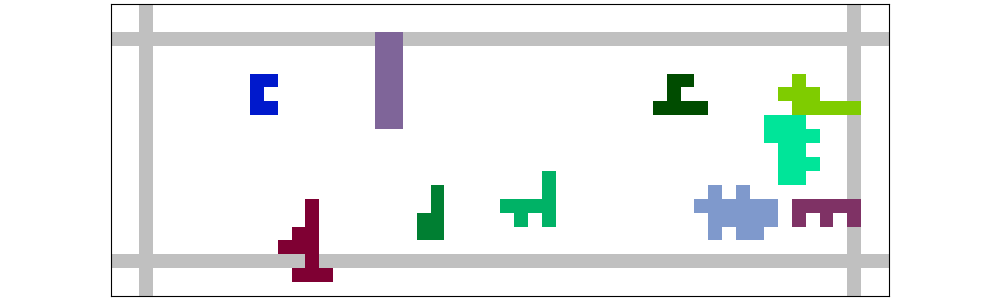

In [82]:
# Config magic; don't worry about this variable too much
config = read_config('configs/1a/easy_config.txt', globals(), locals())

# Initialize a solution
solution = LinearGenotype()
solution.random_initialization(**config['problem'])

# Call the fitness function on the solution
output = base_fitness_function(solution.genes, **config['problem'])

# Save the output values into the solution variable
solution.fitness = output['fitness']

print('Fitness:', solution.fitness)

# You can visualize the solution by calling the returned function
visualize(solution.genes, **config['problem'])

# If we wanted to save the visualization to a file, we could have used:
# visualize(solution.genes, path='my/file/path.png', **config['problem'])

In EC terminology, we refer to each call of the fitness function as an evaluation (eval). Keeping track of the number of evals is very important, since it is used as a fair metric for comparing algorithms. If one algorithm took ten seconds to solve a problem on a supercomputer, and another algorithm took ten weeks on a laptop, it's unfair to say the first algorithm was better just because it took less time. Instead, we use evals as the basic unit for measuring the cost of an algorithm (you may hear this concept referred to as *sample efficiency* in general AI jargon).

In order to perform fair comparisons, all experimental runs in this assignment series will consist of 100,000 evaluations. This way we can say that all algorithms were given the same amount of resources.

## HistogramMaker
In any experiment, data collection and visualization are extremely important. To make your job somewhat easier, as well as to ensure everything is in a standardized format, we have provided a tool (`HistogramMaker`) which will collect some of this data for you automatically. To use it, you simply need to pass the fitness values you encounter to its `add` method. The following cell demonstrates the proper usage:

In [83]:
from histogram import HistogramMaker

config = read_config('configs/1a/easy_config.txt', globals(), locals())

# Initializing the HistogramMaker
# In your real search, this would have happened before any evaluations
hist = HistogramMaker(**config['problem'])

# Add the fitness to the HistogramMaker
hist.add(solution.fitness)

As you might have guessed, you'll use the `HistogramMaker` at the end of your experiment to make a histogram. This will visualize the distribution of fitness values encountered during your search. It might look something like this:

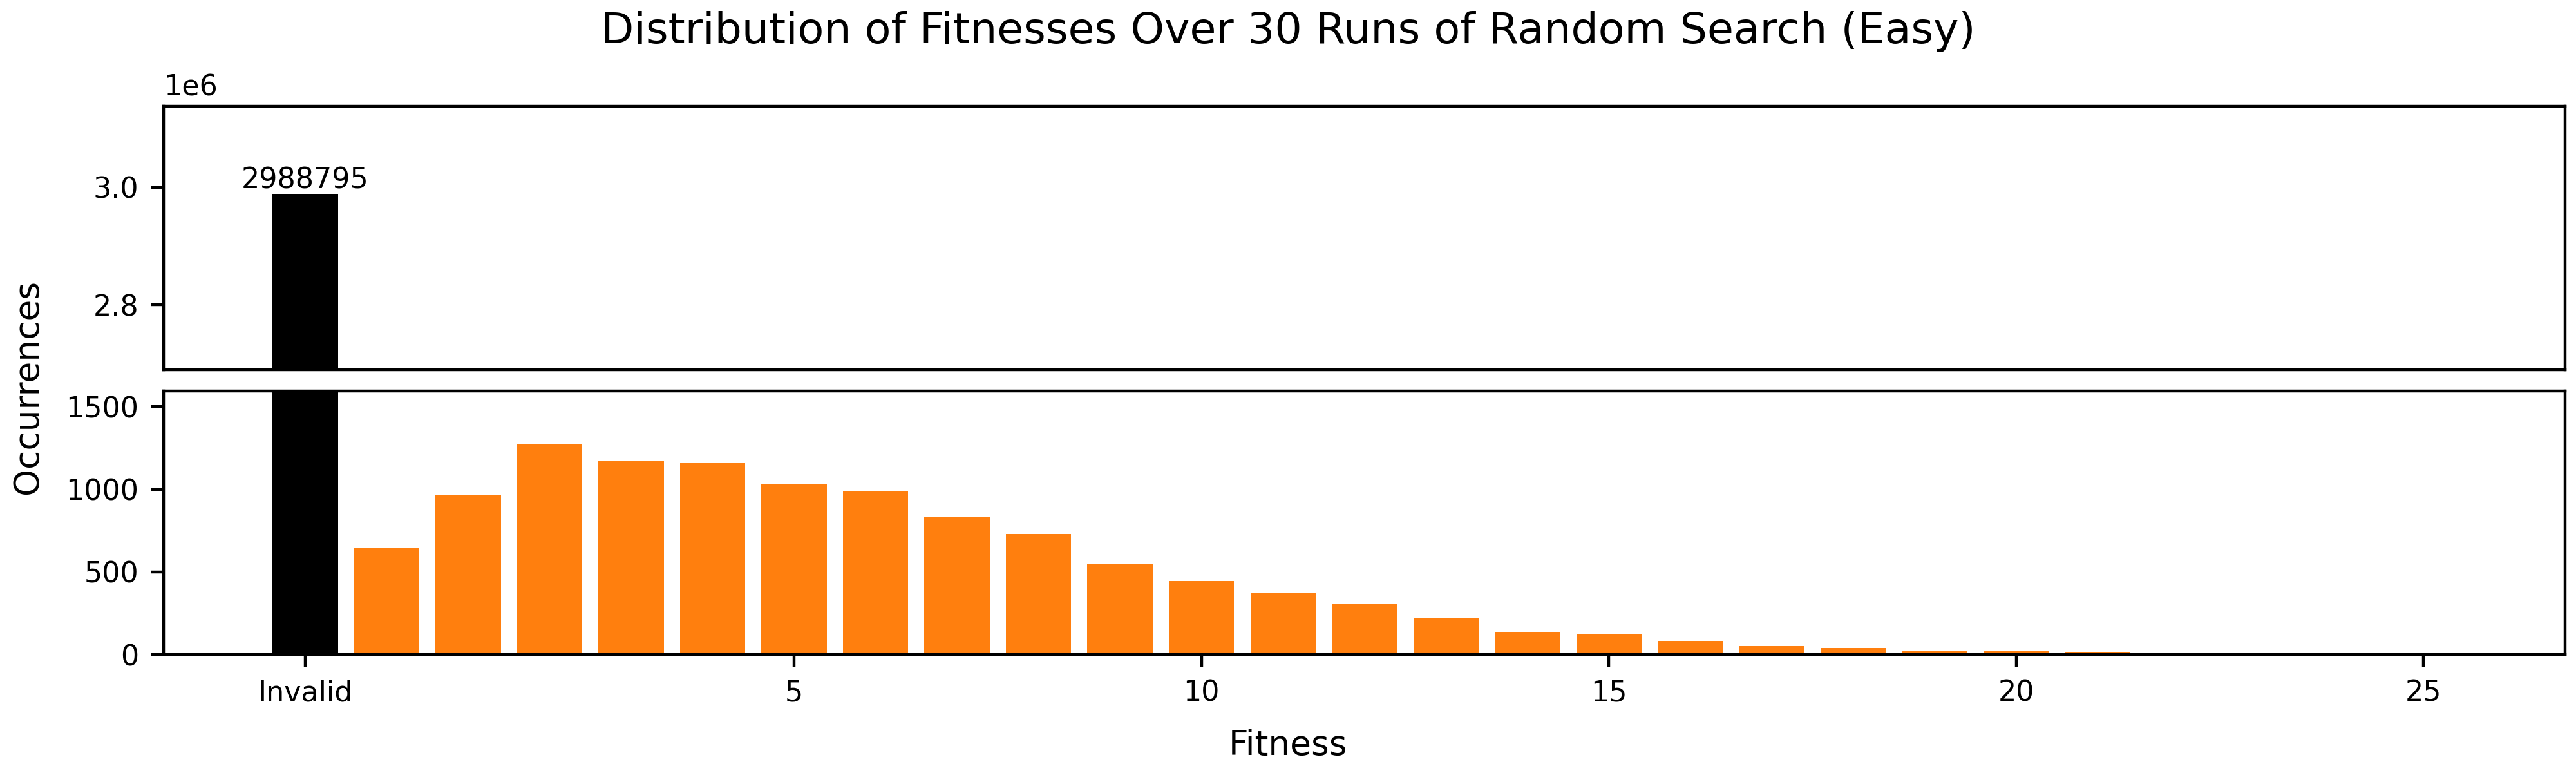

Notice how the bar for invalid solutions extends to a separate y-axis, with a different scale. That is, the visual height of the black bar is not to scale, and the overwhelming majority of solutions were invalid. That is normal for this assignment; if your histogram doesn't have that feature, your implementation is incorrect.

The histograms are very valuable for visualizing the distribution of fitness values over the course of your search. This can help you to better understand how effective your algorithm is at creating solutions of various fitnesses. For example, in the above histogram, we see the algorithm sometimes creates high-fitness solutions, but most often creates low-fitness solutions. A better algorithm might be able to learn how to make more high-fitness solutions based on the solutions it has already seen.

Later in this assignment series, when you are trying to improve the performance of your algorithms, they will help you understand the impacts of different variables. For this assignment, however, they just help you get an idea of what kinds of solutions your random search generates.

In [84]:
# Delete lingering variables
del config, solution, output, hist

## Random Search Algorithm
As opposed to the more deliberate generate-and-test algorithms you will be creating later in this course, for this assignment you need only implement a random search: a "blind" algorithm that generates solutions randomly, without using any information about previously-evaluated solutions or their fitnesses. At this point, you have everything you need to write such an algorithm! Next, you will write a loop to generate new random solutions, evaluate them, and conduct basic data collection.

In addition to simply performing the random search and collecting histogram data, we also need you to return two forms of data from this function. The first, `best_solution`, is simply the highest-fitness `LinearGenotype` from this run. The second, `stairstep_data`, is more freeform; it's up to you to figure out what data to collect. In this variable, you need to record data to produce a stairstep plot demonstrating the progress of this run as the search was performed. That is, we will plot the number of evaluations vs the greatest fitness value seen so far in the run. For reference, the stairstep plot will look something like this:

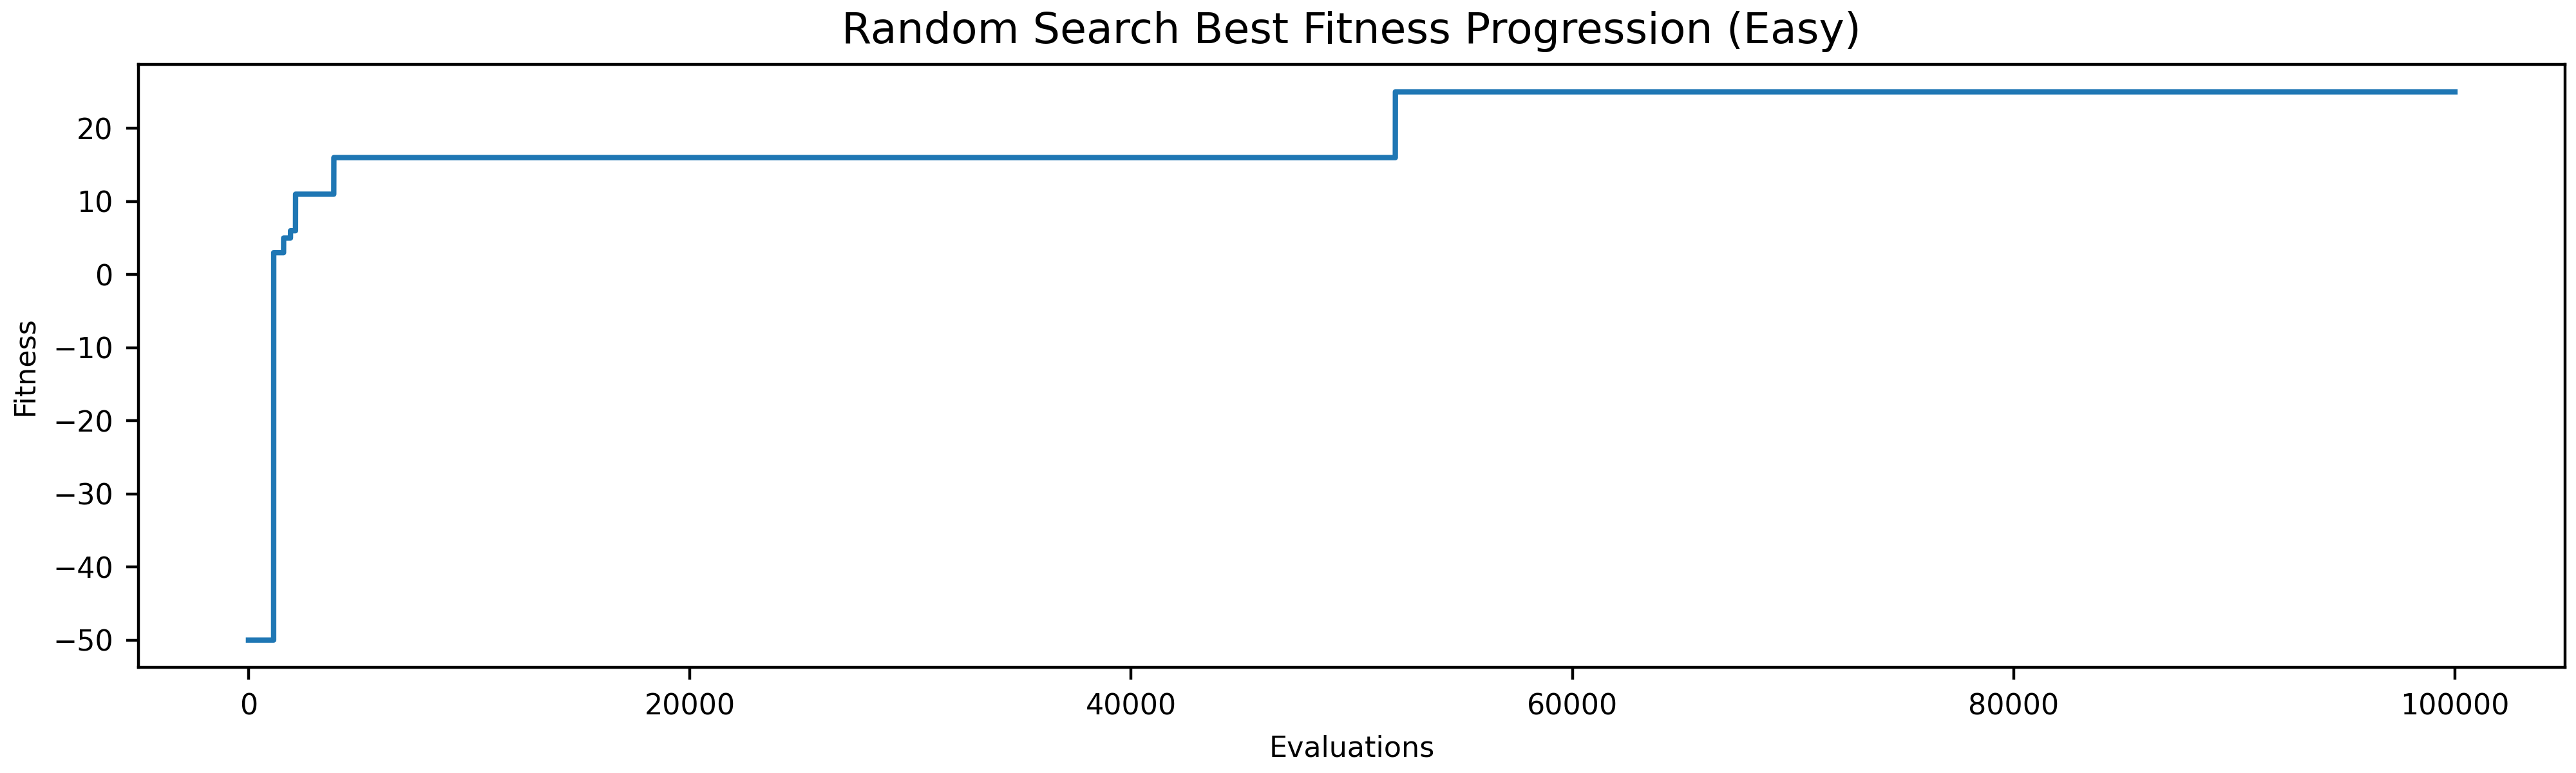

To reiterate, there are three things you need to do beyond just implementing random search:

1. Call `hist.add(solution.fitness)` once on every solution
2. Return the highest-fitness `LinearGenotype` as `best_solution`
3. Return appropriate data for generating a stairstep plot as `stairstep_data`

Now, implement your random search, including this prescribed data collection, in the next cell. If you feel lost, remember to look at how we evaluated solutions in the last few cells! If you feel overwhelmed, focus on getting your random search working first, then move on to data collection.

In [85]:
from math import inf

def random_search_run(num_evaluations, config):
    # Initialize a HistogramMaker
    hist = HistogramMaker(**config['problem'])
    
    # Starting at -inf is a good way to keep track of the best fitness
    best_fitness = -inf

    # Assign your best LinearGenotype to this variable
    best_solution = None

    # Assign your stairstep data to this variable
    # It's up to you to figure out what that data should be!
    stairstep_data = []

    # TODO: Search through and evaluate num_evaluations different random solutions
    #       using the functions we showed in the previous cells:
    #       solution.random_initialization(**config['problem'])
    #       output = base_fitness_function(solution.genes, **config['problem'])
    #       hist.add(solution.fitness)

    for _ in range(num_evaluations):
        solution = LinearGenotype()
        solution.random_initialization(**config['problem'])
        
        # Call the fitness function on the solution
        output = base_fitness_function(solution.genes, **config['problem'])

        # Save the output values into the solution variable
        solution.fitness = output['fitness']
        hist.add(solution.fitness)

        if solution.fitness > best_fitness:
            best_fitness = solution.fitness
            best_solution = solution
            
        stairstep_data.append(best_fitness)
            
    return best_solution, stairstep_data, hist

Now run the next cell to test your function. This may take a minute or two to run. **If you ever change the function in the previous cell, make sure to execute that cell again so the changes get loaded by the interpreter!** Otherwise, the changes won't take effect in other cells.

Best solution fitness: 18
Best solution looks like:


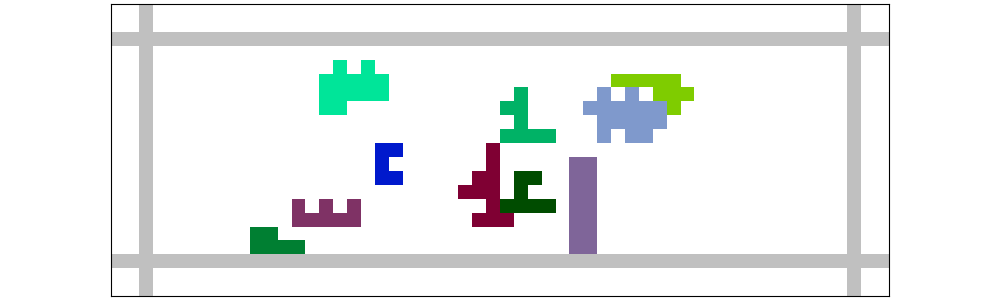

Histogram:


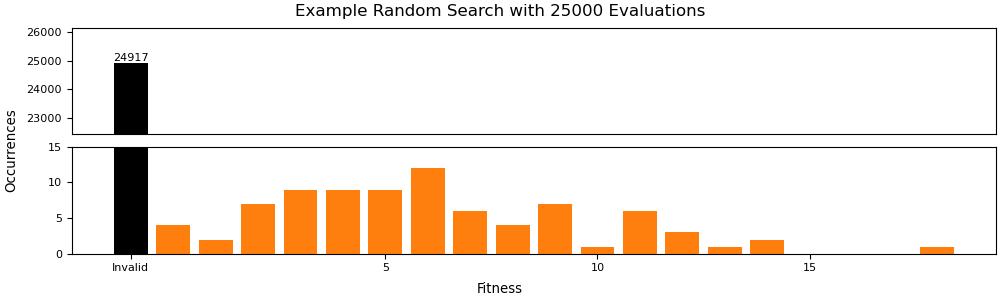

Stairstep data:
[-50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50

In [86]:
config = read_config('configs/1a/easy_config.txt', globals(), locals())
num_evaluations = 25_000 # Smaller eval count, to make this test quicker
hist = HistogramMaker(**config['problem'])

# Call your function
best_solution, stairstep_data, hist = random_search_run(num_evaluations, config)

print('Best solution fitness:', best_solution.fitness)
print('Best solution looks like:')
visualize(best_solution.genes, **config['problem'])

print('Histogram:')
hist.get_plot(f'Example Random Search with {num_evaluations} Evaluations').show()

print('Stairstep data:')
print(stairstep_data)

del config, num_evaluations, hist, best_solution, stairstep_data

## Serialization & Deserialization
It's often useful to save and load solutions to/from a static representation (e.g., a file or a string). This is obviously useful for obtaining permanent, reusable solutions at the end of optimization, but serialization (saving) and deserialization (loading) is often necessary for many real-world projects in which fitness evaluation is performed by an external program or process (e.g., a complex simulation possibly using another programming language). In our case, serialization enables us to parallelize your code with multiprocessing later in the notebook.

We ask you to implement these capabilities in `LinearGenotype.serialize` and `LinearGenotype.deserialize`, respectively. Note you only need to serialize and deserialize the genes, not the fitness value. How you do this is up to you, and depends on how you've implemented your genotype. The following cell will check that your functions work correctly.

In [87]:
config = read_config('configs/1a/easy_config.txt', globals(), locals())

for i in range(5):
    # Generate a random solution
    random_solution = LinearGenotype()
    random_solution.random_initialization(**config['problem'])

    # Serialize it
    serialization = random_solution.serialize()
    print('Random solution:', serialization)

    # Deserialize to reconstruct the solution as a new LinearGenotype
    deserialized = LinearGenotype()
    deserialized.deserialize(serialization)
    reserialization = deserialized.serialize()
    print('Reconstructed solution:', reserialization)

    # Check that these are the same
    print('Were these the same?', serialization == reserialization)

Random solution: [39, 1, 2], [30, 11, 1], [32, 9, 1], [30, 10, 2], [40, 2, 1], [36, 3, 0], [40, 12, 0], [9, 9, 0], [24, 5, 1], [4, 7, 1]
Reconstructed solution: [39, 1, 2], [30, 11, 1], [32, 9, 1], [30, 10, 2], [40, 2, 1], [36, 3, 0], [40, 12, 0], [9, 9, 0], [24, 5, 1], [4, 7, 1]
Were these the same? True
Random solution: [25, 5, 2], [3, 10, 3], [34, 11, 3], [21, 7, 2], [38, 3, 2], [49, 3, 1], [38, 14, 0], [34, 7, 0], [6, 14, 3], [1, 4, 3]
Reconstructed solution: [25, 5, 2], [3, 10, 3], [34, 11, 3], [21, 7, 2], [38, 3, 2], [49, 3, 1], [38, 14, 0], [34, 7, 0], [6, 14, 3], [1, 4, 3]
Were these the same? True
Random solution: [12, 10, 1], [16, 6, 2], [37, 14, 2], [38, 1, 3], [11, 9, 1], [23, 6, 1], [14, 13, 3], [27, 5, 2], [13, 14, 2], [2, 7, 3]
Reconstructed solution: [12, 10, 1], [16, 6, 2], [37, 14, 2], [38, 1, 3], [11, 9, 1], [23, 6, 1], [14, 13, 3], [27, 5, 2], [13, 14, 2], [2, 7, 3]
Were these the same? True
Random solution: [0, 5, 3], [6, 11, 0], [22, 10, 1], [24, 13, 3], [16, 6, 3

## Full Random Search Experiment
Now, write the code for running a multi-run experiment in the following cell. That is, this function should call `random_search_run`, independently, `num_runs` times. This represents an experiment across multiple independent runs. For data collection, you need to return four things from this function:

1. The highest fitness value encountered in each run (one number per run) as `best_per_run`
2. The highest-fitness `LinearGenotype` found by any of the runs as `best_solution`
3. The `stairstep_data` from the run which produced the best solution
4. The `HistogramMaker` representing the data collected from the runs (**this is already done for you!**)

Note the `multiprocess_helper` function is completed for you. This function will help parallelize your runs, which makes experimentation much quicker. It uses your serialization and deserialization code to avoid issues that sometimes arise when parallelizing. Unfortunately, because we are multiprocessing, **any time you change a `.py` file, you need to re-execute the following cell**. Otherwise, you will get pickle encoding errors.

Further, it is possible that you run out of RAM when running an experiment. Unfortunately, when this happens, it can manifest as the program *looking* like it's still running, but the program isn't actually doing anything. If an experiment seems to take a long time, check your CPU utilization. If it's very low, you probably ran out of RAM. Start another experiment and watch your memory utilization carefully. If this appears to be an issue, you can pass `processes=x` to the `multiprocessing.Pool` to limit the number of runs that execute in parallel to at most `x`.

In [88]:
from linear_genotype import LinearGenotype

# Returning a LinearGenotype object can cause pickling issues depending on your implementation.
# This just calls your random search run function, and serializes the best solution.
# We instead return this serialized string and the fitness value, sidestepping the issue.
def multiprocess_helper(num_evaluations, config):
    best_solution, stairstep_data, hist = random_search_run(num_evaluations, config)
    return best_solution.serialize(), best_solution.fitness, stairstep_data, hist


def random_search_experiment(num_runs, num_evaluations, config):
    # We handle this for you; don't worry about the histograms here
    hist_per_run = []

    # Assign the highest fitness value seen in each run to this variable
    # i.e., a list/tuple of num_runs numbers
    best_per_run = []
    
    # Assign your best LinearGenotype to this variable
    # It should be the highest-fitness solution seen across all runs
    best_solution = None

    # Assign the stairstep data from your best run to this variable
    # That is, this is stairstep_data from the same run as best_solution
    stairstep_data = None
    
    # This executes your runs in parallel, using the multiprocess_helper function
    # IMPORTANT: If you are running out of RAM, as mentioned in the above text,
    # you can pass 'processes' keyword argument to multiprocessing.Pool() here
    with multiprocessing.Pool() as pool:
        args = [(num_evaluations, config)] * num_runs
        run_results = list(pool.starmap(multiprocess_helper, args))

    best_total_fitness = -inf

    # Iterate over the completed runs' results
    for i in range(num_runs):
        # This gets the data from run i,
        # deserializes its best solution as run_best_solution,
        # and collects the histogram (don't worry about the histogram)
        run_serialization, run_best_fitness, run_stairstep_data, hist = run_results[i]
        run_best_solution = LinearGenotype()
        run_best_solution.deserialize(run_serialization)
        run_best_solution.fitness = run_best_fitness
        hist_per_run.append(hist)

        # TODO: Use run_best_solution and run_stairstep_data
        #       to collect data in the variables described at
        #       the start of this function
        
        best_per_run.append(run_best_fitness)
        
        # if current run is better than previous best run, update best run with this run information
        if run_best_fitness > best_total_fitness:
            best_total_fitness = run_best_fitness
            best_solution = run_best_solution
            stairstep_data = run_stairstep_data

    # Merge the histograms into one single histogram
    merged_hist = HistogramMaker.merge(hist_per_run)

    return best_per_run, best_solution, stairstep_data, merged_hist

Let's run a quick test in the next cell to make sure everything works, before we embark on a full experiment. As a reminder, **if you change the previous cell, make sure to re-run that cell to save the changes to your function!** We'll do 3 runs of 10,000 evaluations each:

Correct number of best fitnesses? True
Best fitness per run: [16, 17, 16]
Best solution fitness: 17
Best solution looks like:


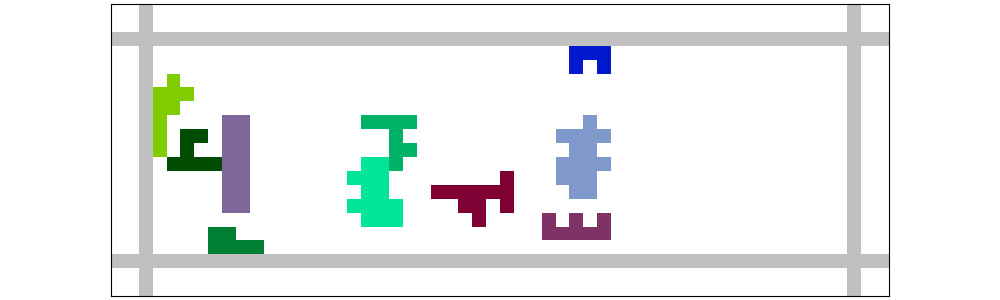

Histogram:


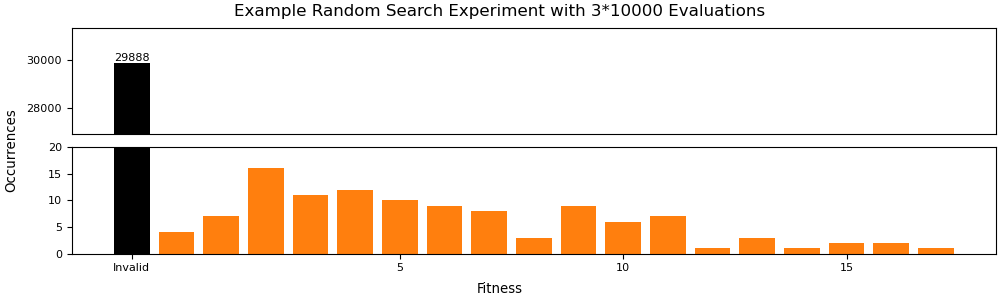

Stairstep data:
[-50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50, -50

In [89]:
example_num_runs = 3
example_num_evaluations = 10_000
easy_config = read_config('configs/1a/easy_config.txt', globals(), locals())

(
    example_best_per_run,
    example_best_solution,
    example_stairstep_data,
    example_hist
) = random_search_experiment(example_num_runs,
                             example_num_evaluations,
                             easy_config)

print('Correct number of best fitnesses?', example_num_runs == len(example_best_per_run))

print('Best fitness per run:', example_best_per_run)
print('Best solution fitness:', example_best_solution.fitness)
print('Best solution looks like:')
visualize(example_best_solution.genes, **easy_config['problem'])

print('Histogram:')
example_hist_plot = example_hist.get_plot('Example Random Search Experiment with ' +\
                                          f'{example_num_runs}*{example_num_evaluations} Evaluations')
example_hist_plot.show()

print('Stairstep data:')
print(example_stairstep_data)

It should go without saying that, when running an experiment, it's important to save your results in a permanent format for later analysis! The following cell defines the function which will do this for you.

In [90]:
def save_data(best_per_run, best_solution, stairstep_data, hist, subdir, config):
    subdir.mkdir(parents=True, exist_ok=True)
    
    with open(subdir / 'best_per_run.txt', 'w') as f:
        for result in best_per_run:
            f.write(str(result) + '\n')

    with open(subdir / 'best_solution.txt', 'w') as f:
        f.write(best_solution.serialize())
    
    visualize(best_solution.genes, path=subdir / 'best_solution.png', **config['problem'])

    with open(subdir / 'stairstep.txt', 'w') as f:
        f.write(str(stairstep_data))
    
    hist.save_to_file(subdir / 'histogram.txt')

    print('Data saved to', subdir)

Now run the next cell to save the results of our test experiment!

In [91]:
save_data(example_best_per_run,
          example_best_solution,
          example_stairstep_data,
          example_hist,
          Path('./data/1a/example/'),
          easy_config)
example_hist_plot.savefig('data/1a/example/histogram.png')

Data saved to data/1a/example


Outside of this notebook, navigate to `./data/1a/example/` and take a look at what was saved. Make sure everything is there, and the data matches what we printed above.

If everything works as expected, run the following cell to run your full experiment and save the data! Note this may take a while, as we are generating and testing quite a few solutions.

In [92]:
num_runs = 30
num_evaluations = 100_000
easy_config = read_config('configs/1a/easy_config.txt', globals(), locals())

(
    easy_best_per_run,
    easy_best_solution,
    easy_stairstep_data,
    easy_hist
) = random_search_experiment(num_runs,
                             num_evaluations,
                             easy_config)

save_data(easy_best_per_run,
          easy_best_solution,
          easy_stairstep_data,
          easy_hist,
          Path('./data/1a/easy/'),
          easy_config)

Data saved to data/1a/easy


# Preparing the Report
Now that you've completed the implementation of random search, you need to use the data you've generated to create the report requested in the assignment description document. This report requires statistical analysis, a histogram, and a stairstep plot, which we will walk through here.

## Statistical Analysis
Your statistical analysis will be comparing the performance of your random search to the data found in `data/1a/easy_mystery_data.txt`. That data is drawn from 30 runs of a different search algorithm, and the values represent the best fitness found during each run of that algorithm. You should have collected analogous data from your random search, as described above.

We will perform statistical analysis using independent t-tests without assuming equal variance. This is accomplished by using the function `stats.ttest_ind(sample1, sample2, equal_var=False)` from the `scipy` package. This will return an object which includes a `pvalue` member. As you will recall from your statistics course, statistical tests are designed so you can compare the $p$-value to a predetermined threshold ($\alpha$) in order to accept or reject the null hypothesis. For this class, $\alpha = 0.05$. You should also recall that the null hypothesis for a t-test is that the two sampled distributions have the same true mean. Since the populations here represent the best fitness values found by different algorithms, the null hypothesis is that the two algorithms are equally effective at solving the problem.

We've provided code which conducts this analysis for you (`stats.py`); you only need to interpret the results. Report the $p$-value displayed by this cell, compare it to $\alpha = 0.05$, and use this information to draw conclusions about the relative performance of your random search and the mystery algorithm. Your report must include:

* Mean and standard deviation for each dataset
* Sample size/degrees of freedom (30)
* $p$ and $\alpha$
* A written-English interpretation of the test result. As an example of what we're looking for, you could say something like `p is (less/greater) than alpha, meaning the two algorithms (do/do not) have statistically significant differences in performance`.
    * If they do have differences in performance, state which one performs better and how you came to that conclusion.

The following cell will run the statistical analysis and print the results.

In [93]:
from stats import run_stats

run_stats('data/1a/easy/best_per_run.txt', 'data/1a/easy_mystery_data.txt')

Number of samples: 30
data/1a/easy/best_per_run.txt mean: 20.766666666666666
data/1a/easy/best_per_run.txt stdv: 1.813423763803275
data/1a/easy_mystery_data.txt mean: 37.46666666666667
data/1a/easy_mystery_data.txt stdv: 1.0080138659874618
p-value: 6.865672204560257e-39


## Histogram
Now run the following cell to generate the histogram! It will be displayed, as well as saved to `data/1a/easy/histogram.png`. Don't forget to put the histogram in your report!

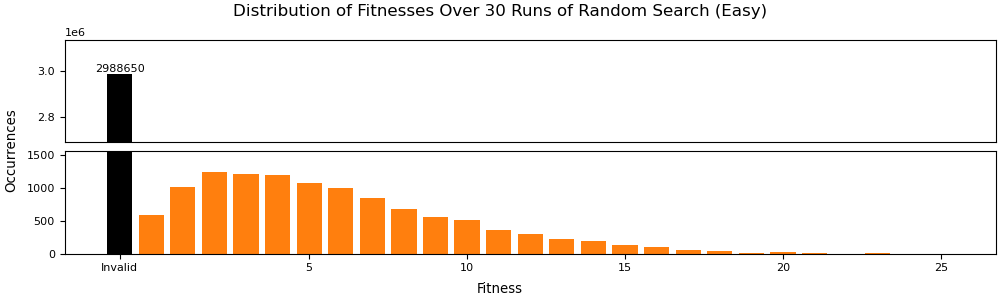

In [94]:
fig = easy_hist.get_plot('Distribution of Fitnesses Over 30 Runs of Random Search (Easy)')
fig.savefig('data/1a/easy/histogram.png')
fig.show()

**Question 1** (1%): In the following cell, use the above histogram to calculate the proportion of valid solutions. State your answer as a decimal with at least five significant figures.

$$\frac{2,988,630\ invalid\ solutions}{30 \cdot 100,000 \ valid\ solutions} = 0.99618$$


**Question 2** (3%): Do the fitness values of *valid* random solutions seem to follow an approximately unimodal distribution, or a strongly multimodal distribution?

Given that there is only one peak in the valid solution distribution, it is a **unimodal distribution**.

## Stairstep Plot
Your experiment should have collected data for generating a stairstep plot showing the progression of the search over the course of a run. We left it up to you to determine what data to gather for this. In this plot, the x-axis should be the number of evaluations, and the y-axis should be fitness. The plotted value is the highest fitness seen so far during the run. The stairstep plot can be generated with the data you've collected using matplotlib's `ax.plot`. You can also use `ax.step` or `ax.stairs` if you wish, but the data formats they take are slightly different: https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.step.html and https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.stairs.html

In the following cell, finish implementing the function which will generate your stairstep plot. All you need to do is write code that transforms `my_data` (which will be whatever data your experiment function returned) into `figure_y_values`, the y-values for the stairstep plot. Depending on how you collected data, this transformation may not even require any work at all. You are also free to rewrite this function's internal logic, if using `ax.step` or `ax.stairs` is simpler for your use-case (note this may require changing the way `figure_x_values` is calculated).

In [95]:
def make_stairstep(my_data, title, filename):
    # Set this to the appropriate y values
    # That is, the y-value that should be displayed, one per evaluation
    figure_y_values = my_data
    
    # x values are 1..num_evaluations if using ax.plot
    # You *probably* don't need to change this
    figure_x_values = [i + 1 for i in range(len(figure_y_values))]
    
    # This will plot the above x and y values for you
    fig, ax = plt.subplots()
    ax.plot(figure_x_values, figure_y_values)
    ax.set(xlabel='Evaluations', ylabel='Fitness', title=title)
    fig.canvas.header_visible = False
    fig.canvas.footer_visible = False
    fig.savefig(filename)

With that function completed, run the following cell to generate your stairstep plot! We'll save it to `data/1a/easy/stairstep.png`, as well as display it. Don't forget to put it in your report!

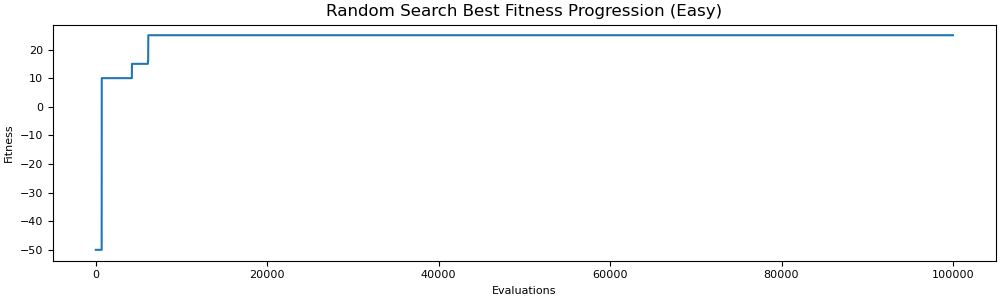

In [96]:
make_stairstep(easy_stairstep_data,
               'Random Search Best Fitness Progression (Easy)',
               'data/1a/easy/stairstep.png')

# Hard Problem Instance
Now run the following cell to do a second experiment on the hard problem instance. This time, we'll compare against the mystery algorithm running on the harder problem instance. Thanks to the way things have been structured, this is a very simple task:

Data saved to data/1a/hard
Number of samples: 30
data/1a/hard/best_per_run.txt mean: 92.33333333333333
data/1a/hard/best_per_run.txt stdv: 20.22857885020227
data/1a/hard_mystery_data.txt mean: 334.93333333333334
data/1a/hard_mystery_data.txt stdv: 8.325007334917897
p-value: 6.885105646535849e-40


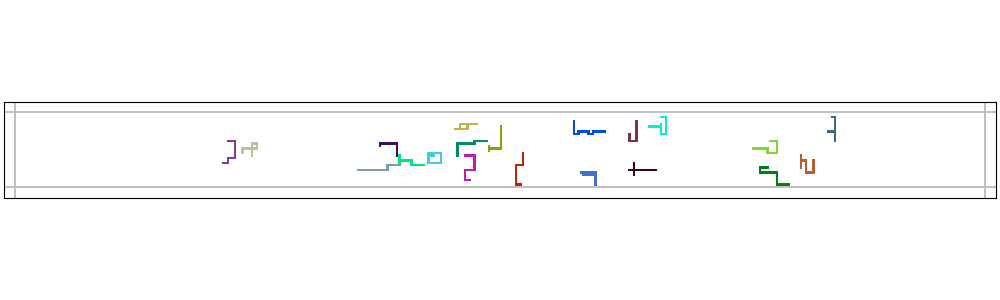

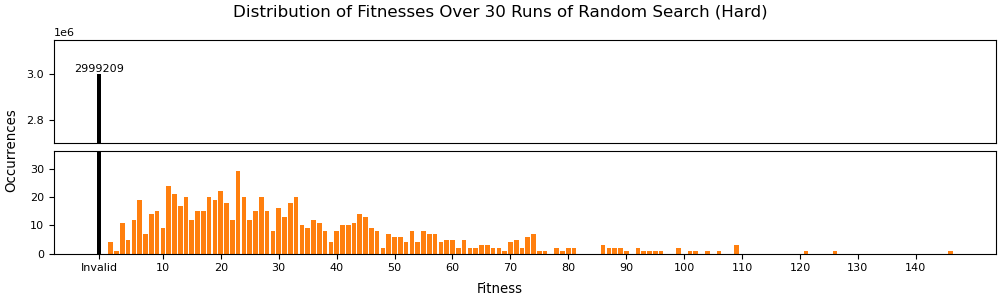

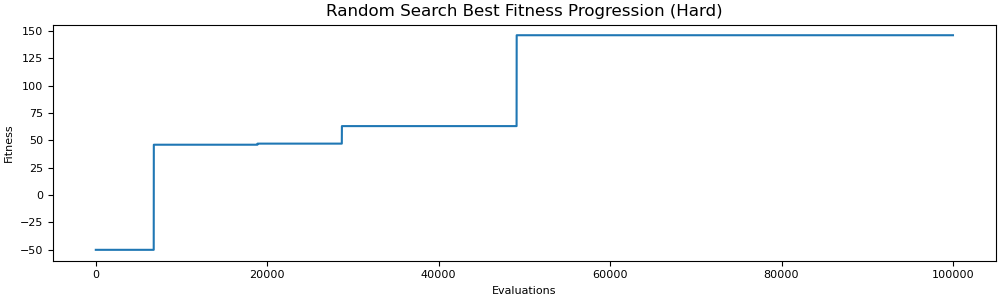

In [97]:
num_runs = 30
num_evaluations = 100_000
hard_config = read_config('configs/1a/hard_config.txt', globals(), locals())

(
    hard_best_per_run,
    hard_best_solution,
    hard_stairstep_data,
    hard_hist
) = random_search_experiment(num_runs,
                             num_evaluations,
                             hard_config)
save_data(hard_best_per_run,
          hard_best_solution,
          hard_stairstep_data,
          hard_hist,
          Path('./data/1a/hard/'),
          hard_config)

run_stats('data/1a/hard/best_per_run.txt', 'data/1a/hard_mystery_data.txt')

visualize(hard_best_solution.genes, **hard_config['problem'])

fig = hard_hist.get_plot('Distribution of Fitnesses Over 30 Runs of Random Search (Hard)')
fig.savefig('data/1a/hard/histogram.png')
fig.show()

make_stairstep(hard_stairstep_data,
               'Random Search Best Fitness Progression (Hard)',
               'data/1a/hard/stairstep.png')

Make sure to include all the same components in your report for the hard problem instance as you did for the easy problem instance. Keep in mind that you cannot directly compare results run on different problem instances. Fitness values are only meaningful in the context of the single problem instance the solution was tested on: if your search's best fitness on the easy instance was 20, and its best fitness on the hard problem was 30, that does NOT mean your algorithm did better on the hard problem instance.

**Question 3** (1%): Calculate the proportion of valid solutions for the hard problem instance, like you did in Question 1. State your answer as a decimal with at least five significant figures.

$$\frac{2,999,303\ invalid\ solutions}{30 \cdot 100,000 \ valid\ solutions} = 0.999768$$
